In [ ]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.model_selection import train_test_split

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

#Read input data
train_data = pd.read_csv('/content/drive/MyDrive/ML/housing-prices-ml-project/data/processed/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/ML/housing-prices-ml-project/data/processed/test.csv')


In [ ]:
# Specify features and target
X_train = train_data.drop(columns=["Id", "SalePrice"])
Y_train = train_data['SalePrice']

X_test = test_data.drop(columns=["Id"])

## lightgbm

In [46]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Initialize LightGBM Regressor with tuned parameters
model = LGBMRegressor(
    n_estimators=1000,      # more boosting rounds
    learning_rate=0.05,     # slower, more stable learning
    num_leaves=31,
    max_depth=-1,
    min_child_samples=7,
    max_bin=38,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Get cross-validated predictions
y_pred_cv = cross_val_predict(model, X_train, Y_train, cv=cv)

# Evaluate regression metrics
mse = mean_squared_error(Y_train, y_pred_cv)
rmse = np.sqrt(mse)  # Compute RMSE
r2 = r2_score(Y_train, y_pred_cv)
print(f"CV Root Mean Squared Error: {rmse:.3f}")
print(f"Cross-validated R²: {r2:.4f}")

# Calculate cross-validated scores
mse_scores = -cross_val_score(model, X_train, Y_train, cv=cv, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(mse_scores)  # RMSE per fold
r2_scores = cross_val_score(model, X_train, Y_train, cv=cv, scoring='r2')
print("Max CV RMSE:", round(rmse_scores.max(), 3))
print("Min CV RMSE:", round(rmse_scores.min(), 3))
print("Max CV R²:", round(r2_scores.max(), 3))
print("Min CV R²:", round(r2_scores.min(), 3))

# Retrain the model on the full training set
model.fit(X_train, Y_train)

# Make predictions
Y_pred = model.predict(X_test)

# Prepare submission file
submission = pd.DataFrame({
    "Id": test_data["Id"],
    "SalePrice": Y_pred
})

# Save with full path (Colab default path)
submission.to_csv("/content/drive/MyDrive/ML/housing-prices-ml-project/data/submission/LGBMRegressor.csv", index=False)

CV Root Mean Squared Error: 28886.376
Cross-validated R²: 0.8677
Max CV RMSE: 42423.131
Min CV RMSE: 19192.945
Max CV R²: 0.931
Min CV R²: 0.647


## catboost

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Initialize CatBoost regressor (silent logging with verbose=0)
model = CatBoostRegressor(
    depth=4,
    iterations=558,
    learning_rate=0.446,
    min_data_in_leaf=7,
    random_seed=42,
    verbose=0
)

# K-Fold CV for regression
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validated predictions
y_pred_cv = cross_val_predict(model, X_train, Y_train, cv=cv)

# Regression metrics
mse = mean_squared_error(Y_train, y_pred_cv)
rmse = np.sqrt(mse)  # Compute RMSE
r2 = r2_score(Y_train, y_pred_cv)
print(f"CV Root Mean Squared Error: {rmse:.3f}")
print(f"CV R² Score: {r2:.3f}")

# Calculate cross-validated scores
mse_scores = -cross_val_score(model, X_train, Y_train, cv=cv, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(mse_scores)  # RMSE per fold
r2_scores = cross_val_score(model, X_train, Y_train, cv=cv, scoring='r2')
print("Max CV RMSE:", round(rmse_scores.max(), 3))
print("Min CV RMSE:", round(rmse_scores.min(), 3))
print("Max CV R²:", round(r2_scores.max(), 3))
print("Min CV R²:", round(r2_scores.min(), 3))

# Retrain on the full training set
model.fit(X_train, Y_train)

# Predict on the test set
Y_pred = model.predict(X_test)


CV Root Mean Squared Error: 30741.734
CV R² Score: 0.850
Max CV RMSE: 41667.866
Min CV RMSE: 21480.16
Max CV R²: 0.924
Min CV R²: 0.659


## XGBoost

CV Root Mean Squared Error: 32065.102
Cross-validated R²: 0.837
Max CV RMSE: 40760.064
Min CV RMSE: 23786.897
Max CV R²: 0.896
Min CV R²: 0.674


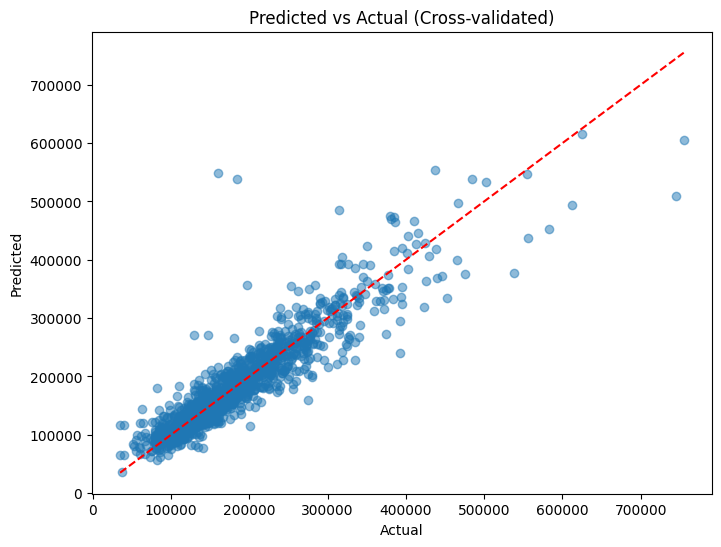

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Initialize XGBoost regressor
model = XGBRegressor(
    max_depth=4,
    n_estimators=558,         # equivalent to iterations/max_iter
    learning_rate=0.446,
    min_child_weight=7,
    random_state=42,
    objective="reg:squarederror"  # regression objective
)

# K-Fold CV for regression
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validated predictions
y_pred_cv = cross_val_predict(model, X_train, Y_train, cv=cv)

# Calculate metrics
mse = mean_squared_error(Y_train, y_pred_cv)
r2 = r2_score(Y_train, y_pred_cv)
rmse = np.sqrt(mse)  # Compute RMSE
print(f"CV Root Mean Squared Error: {rmse:.3f}")
print("Cross-validated R²:", round(r2, 3))

# Calculate cross-validated scores
mse_scores = -cross_val_score(model, X_train, Y_train, cv=cv, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(mse_scores)  # RMSE per fold
r2_scores = cross_val_score(model, X_train, Y_train, cv=cv, scoring='r2')
print("Max CV RMSE:", round(rmse_scores.max(), 3))
print("Min CV RMSE:", round(rmse_scores.min(), 3))
print("Max CV R²:", round(r2_scores.max(), 3))
print("Min CV R²:", round(r2_scores.min(), 3))

# Optional: visualize predicted vs actual
plt.figure(figsize=(8, 6))
plt.scatter(Y_train, y_pred_cv, alpha=0.5)
plt.plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual (Cross-validated)")
plt.show()

# Retrain on the full training set
model.fit(X_train, Y_train)

# Predict on the test set
Y_pred = model.predict(X_test)


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Initialize and fit the Random Forest Regressor with chosen parameters
model = RandomForestRegressor(
    n_estimators=558,      # Number of trees
    max_depth=4,           # Maximum depth of each tree
    min_samples_leaf=7,    # Minimum samples per leaf
    random_state=42,
    n_jobs=-1              # Use all available cores
)

# Cross-validation setup for regression (no stratification needed)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Get cross-validated predictions
y_pred_cv = cross_val_predict(model, X_train, Y_train, cv=cv)

# Calculate and print regression metrics on CV predictions
mse_cv = mean_squared_error(Y_train, y_pred_cv)
r2_cv = r2_score(Y_train, y_pred_cv)
rmse = np.sqrt(mse)  # Compute RMSE
print(f"CV Root Mean Squared Error: {rmse:.3f}")
print(f"Cross-validated R²: {r2_cv:.3f}")

# Calculate cross-validated scores
mse_scores = -cross_val_score(model, X_train, Y_train, cv=cv, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(mse_scores)  # RMSE per fold
r2_scores = cross_val_score(model, X_train, Y_train, cv=cv, scoring='r2')
print("Max CV RMSE:", round(rmse_scores.max(), 3))
print("Min CV RMSE:", round(rmse_scores.min(), 3))
print("Max CV R²:", round(r2_scores.max(), 3))
print("Min CV R²:", round(r2_scores.min(), 3))

# Retrain the model on the full training set
model.fit(X_train, Y_train)

# Make predictions on test set
Y_pred = model.predict(X_test)


CV Root Mean Squared Error: 32065.102
Cross-validated R²: 0.818
Max CV RMSE: 42392.959
Min CV RMSE: 23157.422
Max CV R²: 0.904
Min CV R²: 0.668


## DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Initialize and fit the model with the best parameters
model = DecisionTreeRegressor(
    max_depth=4,
    min_samples_leaf=7,
    random_state=42
)

# Cross-validation setup
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Get cross-validated predictions
y_pred_cv = cross_val_predict(model, X_train, Y_train, cv=cv)

# Calculate regression metrics for CV predictions
mse_cv = mean_squared_error(Y_train, y_pred_cv)
r2_cv = r2_score(Y_train, y_pred_cv)
rmse = np.sqrt(mse)  # Compute RMSE
print(f"CV Root Mean Squared Error: {rmse:.3f}")
print(f"Cross-validated R²: {r2_cv:.3f}")

# Calculate cross-validated scores
mse_scores = -cross_val_score(model, X_train, Y_train, cv=cv, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(mse_scores)  # RMSE per fold
r2_scores = cross_val_score(model, X_train, Y_train, cv=cv, scoring='r2')
print("Max CV RMSE:", round(rmse_scores.max(), 3))
print("Min CV RMSE:", round(rmse_scores.min(), 3))
print("Max CV R²:", round(r2_scores.max(), 3))
print("Min CV R²:", round(r2_scores.min(), 3))

# Retrain the model on the full training set
model.fit(X_train, Y_train)

# Make predictions on test set
Y_pred = model.predict(X_test)


CV Root Mean Squared Error: 32065.102
Cross-validated R²: 0.735
Max CV RMSE: 49065.296
Min CV RMSE: 32354.254
Max CV R²: 0.813
Min CV R²: 0.527


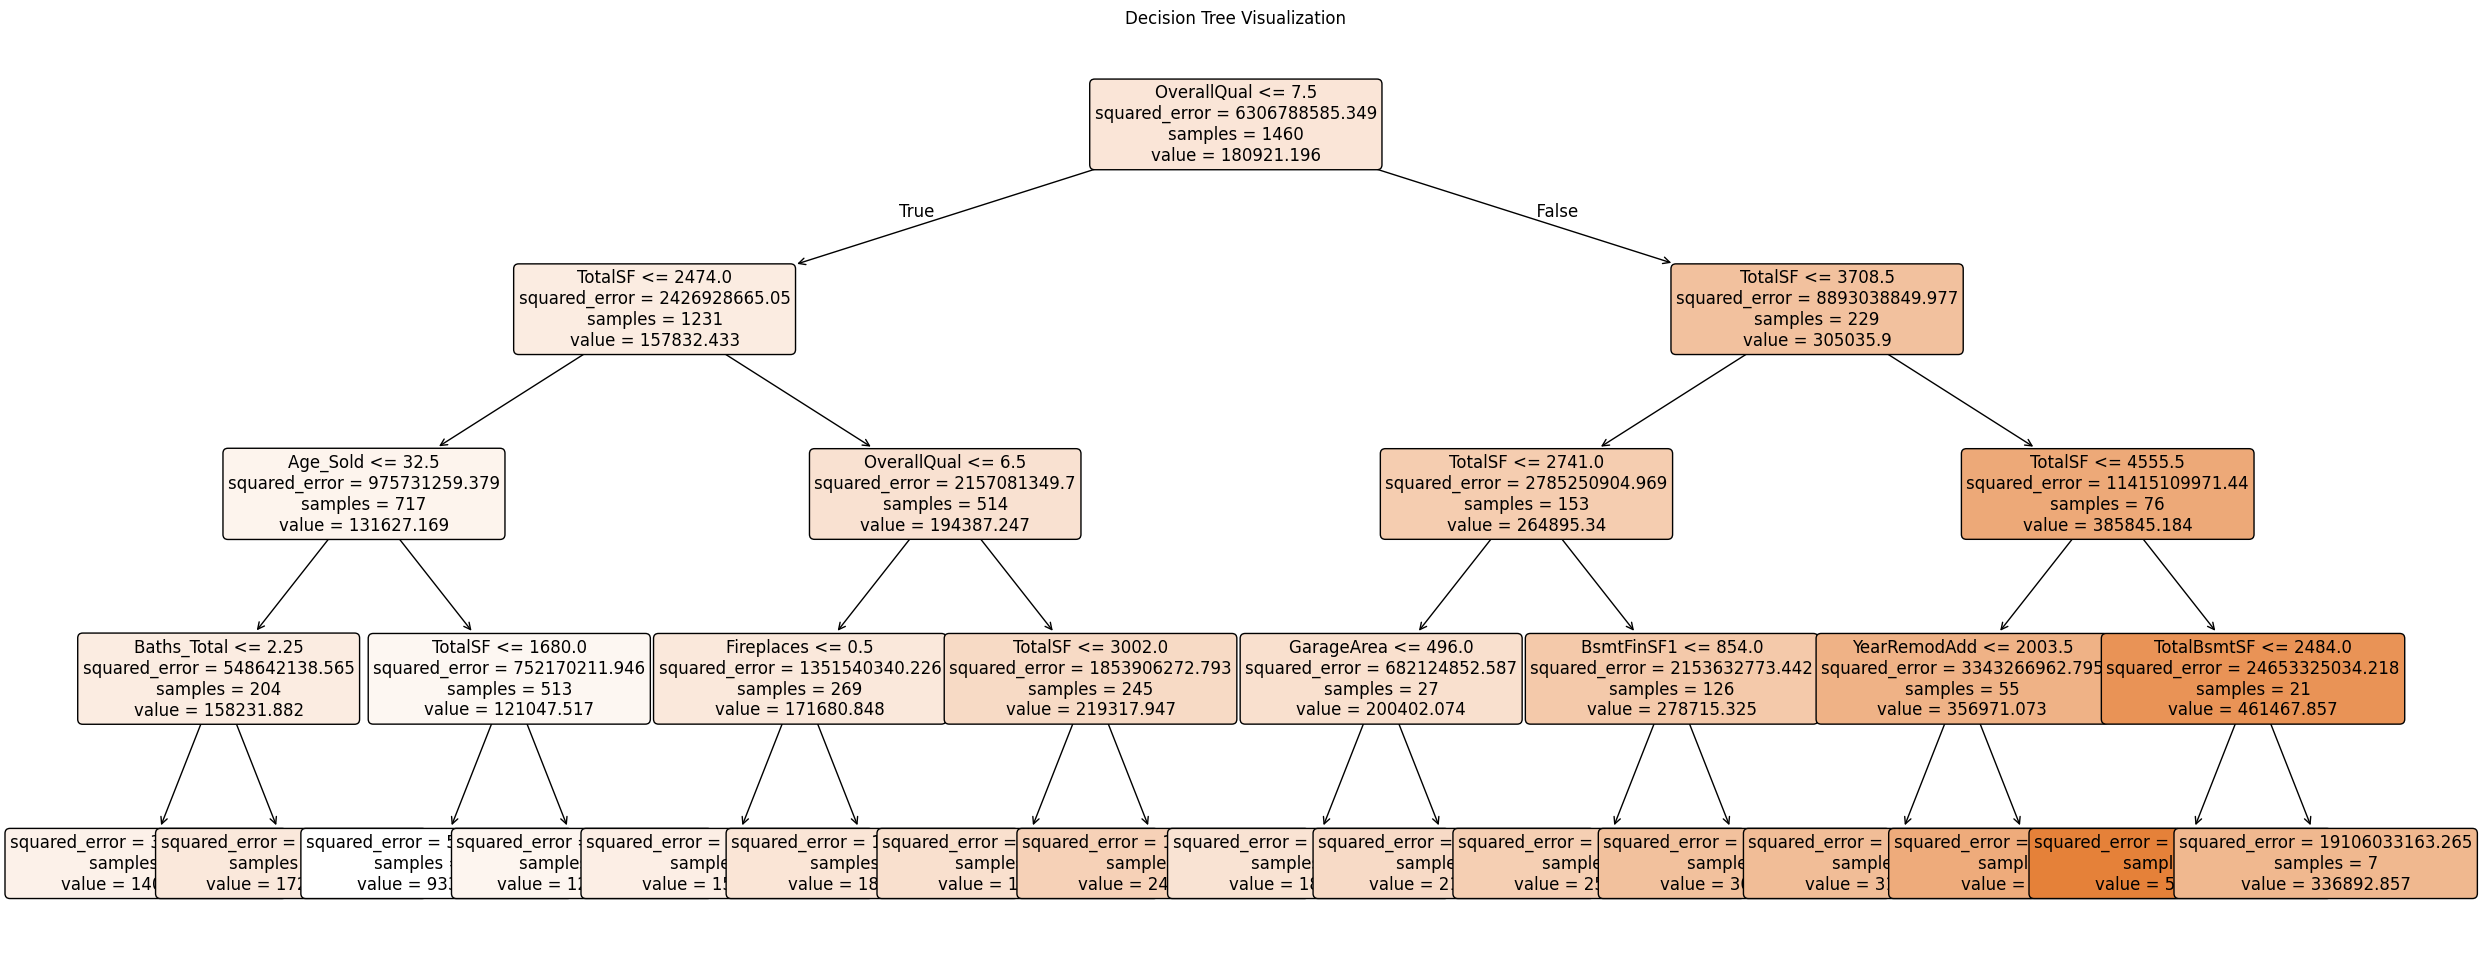

In [ ]:
target_names = ['Didnt Survive', 'Survived']

plt.figure(figsize=(30, 12))
plot_tree(model,
          feature_names=X_train.columns,
          class_names=target_names,
          filled=True,
          rounded=True,
          fontsize=12)
plt.title('Decision Tree Visualization')
plt.show()


## HistGradientBoostingClassifier

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Initialize and fit the model with the best parameters
model = HistGradientBoostingRegressor(
    min_samples_leaf=7,
    max_iter=558,
    max_depth=4,
    max_bins=38,
    learning_rate=0.446,
    early_stopping=True
)

# K-Fold cross-validation (no stratification needed for regression)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Get cross-validated predictions
y_pred_cv = cross_val_predict(model, X_train, Y_train, cv=cv)

# Calculate regression metrics on CV predictions
mse = mean_squared_error(Y_train, y_pred_cv)
r2 = r2_score(Y_train, y_pred_cv)
rmse = np.sqrt(mse)  # Compute RMSE
print(f"CV Root Mean Squared Error: {rmse:.3f}")
print(f"Cross-validated R²: {r2:.3f}")

# Calculate cross-validated scores
mse_scores = -cross_val_score(model, X_train, Y_train, cv=cv, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(mse_scores)  # RMSE per fold
r2_scores = cross_val_score(model, X_train, Y_train, cv=cv, scoring='r2')
print("Max CV RMSE:", round(rmse_scores.max(), 3))
print("Min CV RMSE:", round(rmse_scores.min(), 3))
print("Max CV R²:", round(r2_scores.max(), 3))
print("Min CV R²:", round(r2_scores.min(), 3))

# Retrain the model on the full training set
model.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred = model.predict(X_test)


CV Root Mean Squared Error: 32069.748
Cross-validated R²: 0.837
Max CV RMSE: 50101.131
Min CV RMSE: 22429.132
Max CV R²: 0.908
Min CV R²: 0.631
